In [1]:
####
## Celso Antonio Uliana Junior
## July 2 2020
####

import pandas as pd

#####
## Consuming and shaping the data to analysis
## Covid-19 numbers in Brazil by date
## Isolation percentage in Brazil by date
#####

data_raw_covid = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/covidBrasil.csv", sep = ";", decimal = ",")
data_raw_isolation = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/isolamento.csv", sep = ";", decimal = ",")
data_covid = data_raw_covid['Data'].values.copy()
data_covid = data_raw_covid.dropna().set_index("Data")
data_isolation = data_raw_isolation['Data'].values.copy()
data_isolation = data_raw_isolation.dropna().set_index("Data")

####
## Shaping a central pandas dataFrame for all our ML needs
####

data = data_covid
data['Taxa'] = data_isolation['Taxa'].values.copy()


In [2]:
from sklearn.preprocessing import MinMaxScaler

####
## normalizing values for both covid and isolation percentage 
## between range [0,1] using sklearn MinMaxScaler
####

exp_norm = data_covid["Casos"].values.copy()
exp_norm.shape = (len(exp_norm), 1)

exp_norm_isolation = data_isolation["Taxa"].values.copy()
exp_norm_isolation.shape = (len(exp_norm), 1)

####
## Shaping the central dataFrame with normalized values
####
min_max_scaler = MinMaxScaler()

exp_norm = min_max_scaler.fit_transform(exp_norm)
exp_norm_isolation = min_max_scaler.fit_transform(exp_norm_isolation)

data["CasosNormalizados"] = exp_norm
data["TaxaNormalizadas"] = exp_norm_isolation
data.head(20)

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas
Data,,,,
26/2/20,1,24.7,0.000018,0.000000
27/2/20,0,27.5,0.000000,0.074667
28/2/20,0,26.6,0.000000,0.050667
29/2/20,0,31.4,0.000000,0.178667
1/3/20,1,42,0.000018,0.461333
2/3/20,0,27.7,0.000000,0.080000
3/3/20,0,29,0.000000,0.114667
4/3/20,0,30.2,0.000000,0.146667
5/3/20,1,29.7,0.000018,0.133333


In [3]:
####
## Modeling the data as a window type
####
df = pd.DataFrame()
window_size = 6
for i in range(0, window_size + 1):
    df['E{}'.format(i)] = data['CasosNormalizados'].shift(-i)
    if(i == window_size):
        for j in range(0, window_size + 1):
             df['E{}'.format(j + i + 1)] = data['TaxaNormalizadas'].shift(-j)
        df['E{}'.format(window_size * 2 + 2)] = data['CasosNormalizados'].shift(-window_size)
df = df.iloc[: -window_size * 2]
#print(df)

In [4]:
####
## Manipulating the data to split into X(a window size of values)
## and target, or Y, the value X "produces"
####

arr = df.values

X = arr[:, : -1]
target = arr[:, -1]
#print(X)
#print(target)

In [5]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict

mlp = MLPRegressor(
    hidden_layer_sizes = (10,),  activation = 'relu', solver = 'adam', alpha = 0.001, batch_size = 'auto',
    learning_rate = 'constant', learning_rate_init = 0.01, power_t = 0.5, max_iter = 1000, shuffle = True,
    random_state = 9, tol = 0.0001, verbose = False, warm_start = False, momentum = 0.9, nesterovs_momentum = True,
    early_stopping = False, validation_fraction = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
svr = SVR(kernel = 'linear' ,C = 0.25, epsilon = 0.01, verbose = False, max_iter = 1000)

full_predict_mlp = cross_val_predict(mlp, X, target, cv = 10)
full_predict_svr = cross_val_predict(svr, X, target, cv = 10)

In [6]:
print('Mean Squared Error in MLP: %s' %(metrics.mean_squared_error(target, full_predict_mlp)))
print('Mean Squared Error in SVR: %s' %(metrics.mean_squared_error(target, full_predict_svr)))

print(len(full_predict_mlp))
print(len(full_predict_svr))

print(len(data['CasosNormalizados']))

Mean Squared Error in MLP: 0.011020251167221261
Mean Squared Error in SVR: 0.0005935361759623489
105
105
117


In [7]:
import numpy as np

values_to_add = list()
for i in range(0, window_size * 2):
    values_to_add.append(float('NaN'))
    
full_predict_svr = np.insert(full_predict_svr, 0, values_to_add)
full_predict_svr.shape = (len(full_predict_svr), 1)
    

full_predict_mlp = np.insert(full_predict_mlp, 0, values_to_add)
full_predict_mlp.shape = (len(full_predict_mlp), 1)

print(full_predict_svr.shape)
print(full_predict_mlp.shape)

(117, 1)
(117, 1)


In [8]:
data['Predict_mlp'] = full_predict_mlp
data['Predict_svr'] = full_predict_svr
data

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas,Predict_mlp,Predict_svr
Data,,,,,,
26/2/20,1,24.7,0.000018,0.000000,NaN,NaN
27/2/20,0,27.5,0.000000,0.074667,NaN,NaN
28/2/20,0,26.6,0.000000,0.050667,NaN,NaN
29/2/20,0,31.4,0.000000,0.178667,NaN,NaN
1/3/20,1,42,0.000018,0.461333,NaN,NaN
...,...,...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000,0.443905,0.614656
18/6/20,32188,38.5,0.587683,0.368000,0.450684,0.583369
19/6/20,22765,34.7,0.415640,0.266667,0.447164,0.526840


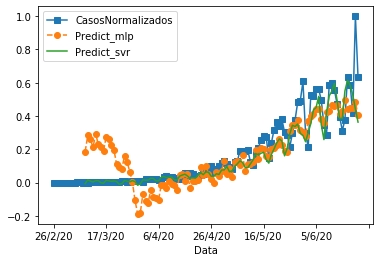

In [9]:
import matplotlib.pyplot as plt
data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr'], style=['-s', '--o'])
plt.show()